In [1]:
import numpy as np
from math import pi, sqrt, tanh, comb
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from ipywidgets import interact
from os import path

import plotly.graph_objects as go
import pandas as pd

import time


In [3]:
def Hilbertspace_Zr(N,r):

    states=np.zeros((r**N,N),dtype=int)

    if N>0:
        for i_1 in range(r**N):
            num_str=np.base_repr(i_1,base=r)[::-1]
            for i_2 in range(len(num_str)):
                states[i_1,i_2]=int(num_str[i_2])
    else:
        states=[[0]]
        
    return states

def p_transpose_2(V,Na,Nb):
# partial transpose with respect to subsystem 2
# the basis of NaxNb density matrix is defined by Nb*(i-1)+j,
# i,j=1,2,3 spans the Hilbert space of subsystem 1 and 2 respectively
    U=np.zeros((Na*Nb,Na*Nb), dtype=np.complex128)
    for i_1 in range(Na):
        for i_2 in range(Na):
#             print(V[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)].shape)
            U[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)]=np.transpose(V[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)])

    return U

def vNent_calc(rho,epsilon=1e-9):
    chi0 =np.linalg.eigvalsh(rho)
    chi1=chi0[np.nonzero(np.abs(chi0)>epsilon)]
    chi2=chi1[np.nonzero(np.abs(chi1-1)>epsilon)]
    return -np.sum(chi2*np.log(chi2))


In [4]:
from scipy.integrate import quad, nquad

def Gz(z,a,b):
    '''Direct solution to G(z), faster but has numerical instability for large V
    a=  Lb/L2
    b=  Lb*L1/L2
    '''
    a2= (b-1)/z +1j*0
    a1= (a-z)/z +1j*0
    a0= 1/z +1j*0
    Q= (3*a1-a2**2)/9 +1j*0
    R= (9*a2*a1-27*a0-2*a2**3)/54 +1j*0
    D= Q**3 + R**2 +1j*0
    S= (R+D**0.5 +1j*0)**(1/3)
    T= (R-D**0.5 +1j*0)**(1/3)
    z4= -a2/3 + (1-1j*sqrt(3))*Q/S/2-(1+1j*sqrt(3))/2*S
    return np.abs(np.imag(z4))

def integrand(z, a, b):
    return Gz(z,a,b)*np.abs(z)

def neg_calc(a,b):
    '''Calculates logneg by \int P(z)|z| dz
    where P(z) is spectral density'''
    options={'limit':500}
    integral= nquad(integrand, [[-np.inf, np.inf]], args=(a, b),opts=[options,options])[0]
    return integral


# charge projection, decomposed partial transpose

In [ ]:
Nrep = 10000
r=2 # local Hilbert space dim
symm=1

La=5
Lb=5
Na=r**La
Nb=r**Lb

Lc=12

Npt = int((La+Lb+Lc)/2)
# Npt_ab_list = np.arange(max(Npt-Lc,1),int((La+Lb))+1)
# Npt_ab_list=np.arange(2,Npt)
Npt_ab_list=np.arange(3,7)

Nc=r**Lc

if symm==1:
    Nab_r=r**(La+Lb-1)
    s_ab=Hilbertspace_Zr(La+Lb,r)
    i_ab=[]
    ### indices for occupation numbers
    for i_r in range(La+Lb+1):
        i_ab.append(np.argwhere(np.sum(s_ab,axis=1)==i_r)[:,0])

    s_c=Hilbertspace_Zr(Lc,r)
    i_c=[]
    for i_r in range(Lc+1):
        i_c.append(np.argwhere(np.sum(s_c,axis=1)==i_r)[:,0])        

vT=np.zeros(Nrep*Nb*Na)
v2T=np.zeros(Nrep*Nb*Na)

t_timer= time.time()

for i_pt in Npt_ab_list:
    print(Npt,i_pt)
    
    Nab_r = len(i_ab[i_pt]) # size of sub-Hilbert space
    v1T=np.zeros(Nrep*Nab_r)

    X=np.zeros((Na*Nb,Nc), dtype=np.complex128)
    for i_r in range(Nrep):
        i_r
        if symm==1:
            if (Npt-i_pt) <= Lc:
                X[np.ix_(i_ab[i_pt],i_c[Npt-i_pt])]=np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))+ 1j*np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))
        else:
        #### no symmetry
            X=np.random.randn(Na*Nb,Nc)+1j*np.random.randn(Na*Nb,Nc_r)

        mat=np.dot(X,np.matrix(X).H)
        rho= mat / np.trace(mat)

        rT = p_transpose_2(rho,Na,Nb)
        l1T=np.linalg.eigvalsh(rT)
        vT[i_r*Nb*Na:(i_r+1)*Nb*Na] = Nab_r *l1T

        rT1 = rT[np.ix_(i_ab[i_pt],i_ab[i_pt])]
        l1T=np.linalg.eigvalsh(rT1)
        v1T[i_r*Nab_r:(i_r+1)*Nab_r] = Nab_r *l1T
        rT[np.ix_(i_ab[i_pt],i_ab[i_pt])] = 0* rT[np.ix_(i_ab[i_pt],i_ab[i_pt])] 
        l1T=np.linalg.eigvalsh(rT)
        v2T[i_r*Nb*Na:(i_r+1)*Na*Nb] = Nab_r *l1T

        
    out_dir = 'data/' 
    if symm==1:
        f1= 'NS_proj_decomp_U1_%d_%d_Labc_%d_%d_%d_symm.npz' % (Npt,i_pt,La,Lb,Lc)
    else:
        f1= 'NS_proj_decomp_U1_%d_%d_Labc_%d_%d_%d.npz' % (Npt,i_pt,La,Lb,Lc)

    fname = out_dir+f1
    np.savez(fname, evals=vT, evals1=v1T, evals2=v2T, Nrep=Nrep)

elapsed = time.time() - t_timer
print("Finished, elapsed time = %.2f " % (elapsed)+ "sec")


11 3


ES was loaded!


<ipython-input-51-549198986597>:43: RuntimeWarning: divide by zero encountered in true_divide
  P1x += 1/pi*Lg**2*Lγ/(2*np.abs(z))*np.real((4/Lg**2*α*αb-(z**2-(α+αb)/Lg)**2+0j)**0.5)
<ipython-input-51-549198986597>:43: RuntimeWarning: invalid value encountered in multiply
  P1x += 1/pi*Lg**2*Lγ/(2*np.abs(z))*np.real((4/Lg**2*α*αb-(z**2-(α+αb)/Lg)**2+0j)**0.5)


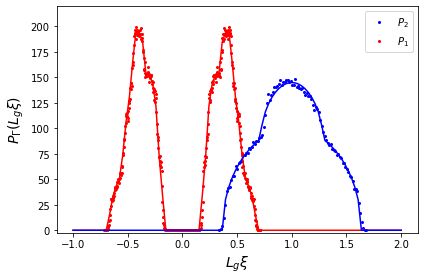

ES was loaded!


<ipython-input-51-549198986597>:43: RuntimeWarning: divide by zero encountered in true_divide
  P1x += 1/pi*Lg**2*Lγ/(2*np.abs(z))*np.real((4/Lg**2*α*αb-(z**2-(α+αb)/Lg)**2+0j)**0.5)
<ipython-input-51-549198986597>:43: RuntimeWarning: invalid value encountered in multiply
  P1x += 1/pi*Lg**2*Lγ/(2*np.abs(z))*np.real((4/Lg**2*α*αb-(z**2-(α+αb)/Lg)**2+0j)**0.5)


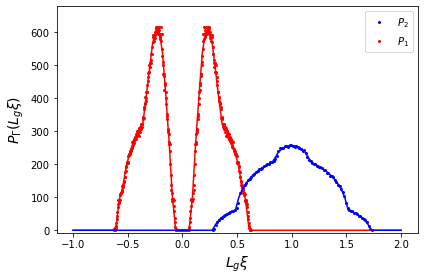

ES was loaded!


<ipython-input-51-549198986597>:43: RuntimeWarning: divide by zero encountered in true_divide
  P1x += 1/pi*Lg**2*Lγ/(2*np.abs(z))*np.real((4/Lg**2*α*αb-(z**2-(α+αb)/Lg)**2+0j)**0.5)
<ipython-input-51-549198986597>:43: RuntimeWarning: invalid value encountered in multiply
  P1x += 1/pi*Lg**2*Lγ/(2*np.abs(z))*np.real((4/Lg**2*α*αb-(z**2-(α+αb)/Lg)**2+0j)**0.5)


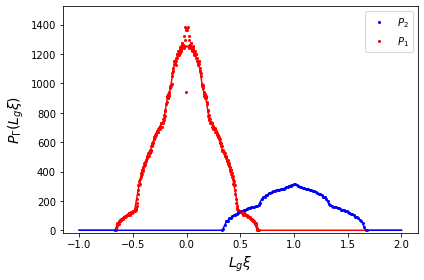

ES was loaded!


<ipython-input-51-549198986597>:33: RuntimeWarning: divide by zero encountered in true_divide
  P1x += 1/pi*Lg**2*Lγ/(2*np.abs(z))*np.real((4/Lg**2*α*αb-(z**2-(α+αb)/Lg)**2+0j)**0.5)
<ipython-input-51-549198986597>:33: RuntimeWarning: invalid value encountered in multiply
  P1x += 1/pi*Lg**2*Lγ/(2*np.abs(z))*np.real((4/Lg**2*α*αb-(z**2-(α+αb)/Lg)**2+0j)**0.5)


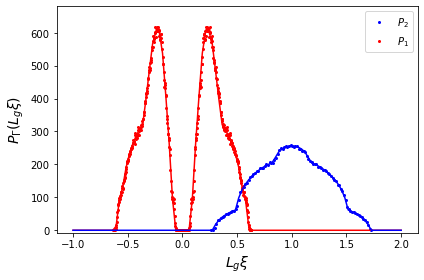

In [51]:
out_dir = "/gscratch/home/hshapourian/RMT/data/" #'data/' 
r=2 # local Hilbert space dim
symm=1

La=5
Lb=5
Na=r**La
Nb=r**Lb

Lc=12

Npt = int((La+Lb+Lc)/2)
# Npt_ab_list = np.arange(max(Npt-Lc,1),int((La+Lb))+1)
Npt_ab_list=np.arange(3,7)

def rmt_dist(z,La,Lb,Lc,Npt_a,Npt_c):
    Lg = comb(La+Lb,Npt_a)
    Lγ = comb(Lc,Npt_c)
    
    z /= Lg
#     z = np.linspace(-2,2,400)/Lg
    P1x = np.zeros(len(z))
    P2x = np.zeros(len(z))

    if Npt_a>La:
        for Np1 in range(La+1):
            α = comb(La,Np1)*comb(Lb,Npt_a-Np1)/(Lg*Lγ)
            P2x += 1/(2*pi)*Lg**2*Lγ*np.real((4/Lg*α-(z-1/Lg)**2+0j)**0.5)
            for Np2 in range(Npt_a+1):
                if Np2 != Npt_a-Np1 :
                    α = comb(La,Np1)*comb(Lb,Np2)/(Lg*Lγ)
                    αb = comb(La,Npt_a-Np1)*comb(Lb,Npt_a-Np2)/(Lg*Lγ)
                    P1x += 1/pi*Lg**2*Lγ/(2*np.abs(z))*np.real((4/Lg**2*α*αb-(z**2-(α+αb)/Lg)**2+0j)**0.5)

    else:
        for Np1 in range(Npt_a+1):     
            α = comb(La,Np1)*comb(Lb,Npt_a-Np1)/(Lg*Lγ)
            P2x += 1/(2*pi)*Lg**2*Lγ*np.real((4/Lg*α-(z-1/Lg)**2+0j)**0.5)
            for Np2 in range(Npt_a+1):
                if Np2 != Npt_a-Np1 :
                    α = comb(La,Np1)*comb(Lb,Np2)/(Lg*Lγ)
                    αb = comb(La,Npt_a-Np1)*comb(Lb,Npt_a-Np2)/(Lg*Lγ)
                    P1x += 1/pi*Lg**2*Lγ/(2*np.abs(z))*np.real((4/Lg**2*α*αb-(z**2-(α+αb)/Lg)**2+0j)**0.5)
    z *= Lg
    return P1x/Lg,P2x/Lg
                
for i_pt in Npt_ab_list:

    plt.figure(figsize=(6,4))
    
    if symm==1:
        f1= 'NS_proj_decomp_U1_%d_%d_Labc_%d_%d_%d_symm.npz' % (Npt,i_pt,La,Lb,Lc)
    else:
        f1= 'NS_proj_decomp_U1_%d_%d_Labc_%d_%d_%d.npz' % (Npt,i_pt,La,Lb,Lc)
    fname = out_dir+f1

    npzfile = np.load(fname)
    vT=npzfile['evals']
    v1T=npzfile['evals1']
    v2T=npzfile['evals2']
    Nrep=npzfile['Nrep']
    print('ES was loaded!')
    
    if r**Lc > 4* r**(La+Lb)+1:
        num_bins = 100
        print(L)
    else:
        num_bins = 100


#     n, bin_edges = np.histogram(vT, bins=num_bins)
#     bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
#     N0=np.sum(n)/Nrep
#     print("total is ", N0)
#     n= n/Nrep/(bin_edges[1]-bin_edges[0])            
#     plt.plot(bins_center,n,'v',markersize=4,color='C%d' % (i_pt-1), label='$N_{ab}$=%d' % (i_pt))

        
    Nab_r = comb(La+Lb,i_pt) # size of sub-Hilbert space
    n, bin_edges = np.histogram(v1T, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
#     print(np.sum(n)/Nrep-Nab_r-N0)
    n= n/Nrep/(bin_edges[1]-bin_edges[0])            
#     plt.plot(bins_center,n,'o',markersize=2,color='b' , label=r'$G_2, N_{pt}$=%d' % (i_pt))
    plt.plot(bins_center,n,'o',markersize=2,color='b' , label=r'$P_2$')

    num_bins = 400
    n, bin_edges = np.histogram(v2T, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    n= n/Nrep/(bin_edges[1]-bin_edges[0])            
    plt.plot(bins_center,n,'o',markersize=2,color='r' , label=r'$P_1$')

    ymax=np.sort(n)[-3]*1.1
    plt.legend()
    plt.ylim(-ymax/100,ymax)

    
    xplot=np.linspace(-1,2,100)
    P1x, P2x = rmt_dist(xplot,La,Lb,Lc,i_pt,Npt- i_pt)
    plt.plot(xplot,P1x,color='r')
    plt.plot(xplot,P2x,color='b')

    lw=0.2

# plt.plot( [0,0],[0,ymax],'k--',linewidth=lw)
# plt.xscale("log")
# plt.yscale("log")
    # plt.xlim(-10,10)
    # plt.yticks(np.arange(0.,ymax+0.1,0.5))
    # plt.legend()
    fsize=14
    plt.ylabel(r'$P_\Gamma(L_g\xi)$',fontsize = fsize)
    plt.xlabel(r"$L_g \xi$",fontsize = fsize)

    plt.tight_layout()
    plt.savefig('figs/sc_u1_pt_%d_ptA_%d_NA_%d_NB_%d_symm.pdf' % (Npt,i_pt,La+Lb,Lc))
    plt.show()

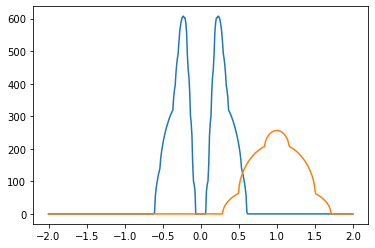

In [31]:
r=2 # local Hilbert space dim

La=5
Lb=5
Na=r**La
Nb=r**Lb

Lc=12   

Npt = int((La+Lb+Lc)/2)
Npt_a = 6
Npt_c = Npt-Npt_a


Lg = comb(La+Lb,Npt_a)
Lγ = comb(Lc,Npt_c)

z = np.linspace(-2,2,400)/Lg
P1x = np.zeros(len(z))
P2x = np.zeros(len(z))

if Npt_a>La:
    for Np1 in range(La+1):
        α = comb(La,Np1)*comb(Lb,Npt_a-Np1)/(Lg*Lγ)
        P2x += 1/(2*pi)*Lg**2*Lγ*np.real((4/Lg*α-(z-1/Lg)**2+0j)**0.5)
        for Np2 in range(Npt_a+1):
            if Np2 != Npt_a-Np1 :
                α = comb(La,Np1)*comb(Lb,Np2)/(Lg*Lγ)
                αb = comb(La,Npt_a-Np1)*comb(Lb,Npt_a-Np2)/(Lg*Lγ)
                P1x += 1/pi*Lg**2*Lγ/(2*np.abs(z))*np.real((4/Lg**2*α*αb-(z**2-(α+αb)/Lg)**2+0j)**0.5)

else:
    for Np1 in range(Npt_a+1):     
        α = comb(La,Np1)*comb(Lb,Npt_a-Np1)/(Lg*Lγ)
        P2x += 1/(2*pi)*Lg**2*Lγ*np.real((4/Lg*α-(z-1/Lg)**2+0j)**0.5)
        for Np2 in range(Npt_a+1):
            if Np2 != Npt_a-Np1 :
                α = comb(La,Np1)*comb(Lb,Np2)/(Lg*Lγ)
                αb = comb(La,Npt_a-Np1)*comb(Lb,Npt_a-Np2)/(Lg*Lγ)
                P1x += 1/pi*Lg**2*Lγ/(2*np.abs(z))*np.real((4/Lg**2*α*αb-(z**2-(α+αb)/Lg)**2+0j)**0.5)


plt.figure()
plt.plot(z*Lg,P1x/Lg)
plt.plot(z*Lg,P2x/Lg)
# print(fx)

In [23]:
np.arange(-2,2,0.001)
# def LAg(La1,La2,Npt_a):
#     return comb(La1+La2,Npt_a)
# #     y = 0
# #     if Npt_a>La1:
# #         for Np1 in range(La1+1):
# #             y += comb(La1,Np1)*comb(La2,Npt_a-Np1)
# #     else:
# #         for Np1 in range(Npt_a+1):
# #             y += comb(La1,Np1)*comb(La2,Npt_a-Np1)
# #     return y


array([-2.   , -1.999, -1.998, ...,  1.997,  1.998,  1.999])

In [68]:
Nrep=1000
r=2 # local Hilbert space dim
symm=1

La=6
Lb=2
Na=r**La
Nb=r**Lb

Lc=5

Npt = int((La+Lb+Lc)/2)
# Npt_ab_list = np.arange(max(Npt-Lc,1),int((La+Lb))+1)
# Npt_ab_list=np.arange(2,Npt)
Npt_ab_list=np.array([2])

Nc=r**Lc

if symm==1:
    Nab_r=r**(La+Lb-1)
    s_ab=Hilbertspace_Zr(La+Lb,r)
    i_ab=[]
    ### indices for occupation numbers
    for i_r in range(La+Lb+1):
        i_ab.append(np.argwhere(np.sum(s_ab,axis=1)==i_r)[:,0])

    s_c=Hilbertspace_Zr(Lc,r)
    i_c=[]
    for i_r in range(Lc+1):
        i_c.append(np.argwhere(np.sum(s_c,axis=1)==i_r)[:,0])        

vT=np.zeros(Nrep*Nb*Na)
v2T=np.zeros(Nrep*Nb*Na)

t_timer= time.time()

for i_pt in Npt_ab_list:
    print(Npt,i_pt)
    
    Nab_r = len(i_ab[i_pt]) # size of sub-Hilbert space
    v1T=np.zeros(Nrep*Nab_r)

    X=np.zeros((Na*Nb,Nc), dtype=np.complex128)
    
    dz= 5e-3
    zsw = np.linspace(-5,5,100) + 1j*dz
    G= np.zeros((Na*Nb,Na*Nb,len(zsw))) 
    for i_r in range(Nrep):
        i_r
        if symm==1:
            if (Npt-i_pt) <= Lc:
                X[np.ix_(i_ab[i_pt],i_c[Npt-i_pt])]=np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))+ 1j*np.random.randn(len(i_ab[i_pt]),len(i_c[Npt-i_pt]))
        else:
        #### no symmetry
            X=np.random.randn(Na*Nb,Nc)+1j*np.random.randn(Na*Nb,Nc_r)

        mat=np.dot(X,np.matrix(X).H)
        rho= mat / np.trace(mat)

        rT = p_transpose_2(rho,Na,Nb)
        l1T=np.linalg.eigvalsh(rT)
        vT[i_r*Nb*Na:(i_r+1)*Nb*Na] = Nab_r *l1T
        for i_z in range(len(zsw)):
            G[:,:,i_z] += np.imag(np.linalg.inv(zsw[i_z]*eye(Na*Nb)-Nab_r*rT))
            
#         rT1 = rT[np.ix_(i_ab[i_pt],i_ab[i_pt])]
#         l1T=np.linalg.eigvalsh(rT1)
#         v1T[i_r*Nab_r:(i_r+1)*Nab_r] = Nab_r *l1T
#         rT[np.ix_(i_ab[i_pt],i_ab[i_pt])] = 0* rT[np.ix_(i_ab[i_pt],i_ab[i_pt])] 
#         l1T=np.linalg.eigvalsh(rT)
#         v2T[i_r*Nb*Na:(i_r+1)*Na*Nb] = Nab_r *l1T

        
#     out_dir = 'data/' 
#     if symm==1:
#         f1= 'NS_proj_decomp_U1_%d_%d_Labc_%d_%d_%d_symm.npz' % (Npt,i_pt,La,Lb,Lc)
#     else:
#         f1= 'NS_proj_decomp_U1_%d_%d_Labc_%d_%d_%d.npz' % (Npt,i_pt,La,Lb,Lc)

#     fname = out_dir+f1
#     np.savez(fname, evals=vT, evals1=v1T, evals2=v2T, Nrep=Nrep)
    G /= Nrep

elapsed = time.time() - t_timer
print("Finished, elapsed time = %.2f " % (elapsed)+ "sec")


6 2
Finished, elapsed time = 390.76 sec


(-0.1, 12.0)

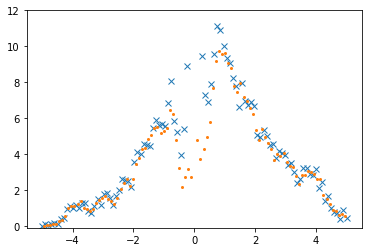

In [69]:
trG = np.zeros(len(zsw))
for i_z in range(len(zsw)):
    trG[i_z] = np.trace(G[:,:,i_z])
plt.plot(np.real(zsw),-trG/pi,'x')


num_bins = len(zsw) -1 
n, bin_edges = np.histogram(vT, bins=np.real(zsw))
bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
n= n/Nrep/(bin_edges[1]-bin_edges[0])            
plt.plot(bins_center,n,'.',markersize=4)#, label='$N_{ab}$=%d' % (i_pt))
plt.ylim([-0.1,12])
    

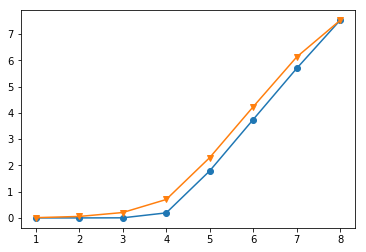

In [19]:
neg_full_avg=np.mean(neg_full,axis=1)
neg_symm_avg=np.mean(neg_symm,axis=1)
plt.figure()
plt.plot(La_sw,neg_full_avg,'o-')
plt.plot(La_sw,neg_symm_avg,'v-')
plt.show()

In [ ]:
neg_avg1=np.mean(neg_q,axis=1)
print(neg_avg1)
plt.figure()
plt.plot(La_sw,neg_avg1,'o-')
# plt.plot(La_sw,negb,'v')
plt.show()

In [ ]:
Nrep=10
r=2 # local Hilbert space dim

L=12
La_sw=[6] #range(1,4)
# La_sw=range(1,int(L/2)+1)

negb=np.zeros((len(La_sw),Nrep))
# np.random.seed(1)

t_timer=time.time()

for i_l in range(len(La_sw)):
    La=La_sw[i_l]
    Lb=La
    Lc=L-La-Lb
    print(' ',La)
    
    Na=r**La
    Nb=r**Lb
    Nc=r**Lc
    
    s_c=Hilbertspace_Zr(Lc,r)
    s_ab=Hilbertspace_Zr(La+Lb,r)

    i_ab=np.zeros((r**(La+Lb-1),r),dtype=int)
    if Lc>0:
        i_c=np.zeros((r**(Lc-1),r),dtype=int)
    else:
        i_c=np.zeros((1,r),dtype=int)
    ### indices of r multiples
#     for i_Zr in range(r):
    i_Zr=0
    i_c[:,i_Zr]=np.argwhere(np.mod(np.sum(s_c,axis=1),r)==i_Zr)[:,0]
    i_ab[:,i_Zr]=np.argwhere(np.mod(np.sum(s_ab,axis=1),r)==i_Zr)[:,0]


    Ne_ab=r**(La+Lb-1)
    Ne_c=r**(Lc-1)
    X=np.zeros((Na*Nb,Nc), dtype=np.complex128)

    for i_r in range(Nrep):

        if Lc>0:
            X[np.ix_(i_ab[:,0],i_c[:,0])]=np.random.randn(Ne_ab,Ne_c)+ 1j*np.random.randn(Ne_ab,Ne_c)
        else:
            X[i_ab[:,0],0]=np.random.randn(Ne_ab)+ 1j*np.random.randn(Ne_ab)


        mat=np.dot(X,np.matrix(X).H)
        rho= mat / np.trace(mat)

        rT = p_transpose_2(rho,Na,Nb)
        lT=np.linalg.eigvalsh(rT)
        negb[i_l,i_r]=np.log2(np.sum(np.abs(lT)))

            
elapsed = time.time() - t_timer
print("Finished, elapsed time = %.2f " % (elapsed)+ "sec")


In [ ]:
# print(X)
print(negb)

In [ ]:
negb_avg=np.mean(negb,axis=1)
plt.figure()
plt.plot(La_sw,neg_avg,'o-')
plt.plot(La_sw,negb_avg,'v')
plt.show()

In [14]:
# bipartite entanglement

Nrep=1000
r=5 # local Hilbert space dim

La=3
Lb=0
L=2*La
Lc=L-La-Lb

Na=r**La
Nb=r**Lb
Nc=r**Lc

s_c=Hilbertspace_Zr(Lc,r)
s_ab=Hilbertspace_Zr(La+Lb,r)

i_ab=np.zeros((r**(La+Lb-1),r),dtype=int)
i_c=np.zeros((r**(Lc-1),r),dtype=int)
### indices of r multiples
for i_r in range(r):
    i_c[:,i_r]=np.argwhere(np.mod(np.sum(s_c,axis=1),r)==i_r)[:,0]
    i_ab[:,i_r]=np.argwhere(np.mod(np.sum(s_ab,axis=1),r)==i_r)[:,0]

Nab_r=int(Nb*Na/r)
Nc_r=r**(Lc-1)
X=np.zeros((Na*Nb,Nc), dtype=np.complex128)

ent0=np.zeros(Nrep)
ent1=np.zeros(Nrep)

for i_r in range(Nrep):
    #### no symmetry
    X0=np.random.randn(Na*Nb,Nc)+1j*np.random.randn(Na*Nb,Nc)
    mat=np.dot(X0,np.matrix(X0).H)
    rho= mat / np.trace(mat)    
    ent0[i_r]=vNent_calc(rho)

    X[np.ix_(i_ab[:,0],i_c[:,0])]=np.random.randn(Nab_r,Nc_r)+ 1j*np.random.randn(Nab_r,Nc_r)
    for i_Zr in np.arange(1,r):
        X[np.ix_(i_ab[:,i_Zr],i_c[:,r-i_Zr])]=np.random.randn(Nab_r,Nc_r)+1j*np.random.randn(Nab_r,Nc_r)

#     X[np.ix_(i_ab[:,0],i_c[:,0])]=np.random.randn(Nab_r,Nc_r)+ 1j*np.random.randn(Nab_r,Nc_r)
#     X[np.ix_(i_ab[:,1],i_c[:,1])]=np.random.randn(Nab_r,Nc_r)+ 1j*np.random.randn(Nab_r,Nc_r)
    mat=np.dot(X,np.matrix(X).H)
    rho= mat / np.trace(mat)    
    ent1[i_r]=vNent_calc(rho)
    
print(np.mean(ent0))
print(np.mean(ent1))
print(np.log(Na)-0.5)

4.328390084765682
4.328744035803526
4.3283137373023015


In [ ]:
# rho.shape
# X.shape
# i_ab[:,0]
# np.linalg.eigvalsh(rho)